In [ ]:
!pip install trimesh pyrender tqdm numpy

In [169]:
import os
os.environ["PYOPENGL_PLATFORM"] = "egl"
import numpy as np
import trimesh
import pyrender
import tqdm
from time import process_time 
import torch
import time
from plot_image_grid import image_grid
from pyrender import PerspectiveCamera,\
                     DirectionalLight, SpotLight, PointLight,\
                     MetallicRoughnessMaterial,\
                     Primitive, Mesh, Node, Scene,\
                     Viewer, OffscreenRenderer
import logging

In [163]:
DATA_DIR = "./models"
shapenet_folder = os.path.join(DATA_DIR, "shapenet_sample")
obj_list = []

with open(os.path.join(shapenet_folder, 'pathlist.txt')) as filehandle:
    for line in tqdm.tqdm(filehandle, desc = 'Loading Meshes'):
        obj_folder = line.strip()
        obj_name = os.path.join(shapenet_folder, obj_folder, 'models/model_normalized.obj')
        obj_list.append(obj_name)

Loading Meshes: 128it [00:00, 80406.01it/s]


In [164]:
def trimesh_to_pyrender(scene, ambient_light=None):
    """                                                                                              
    Convert a trimesh scene to a pyrender scene.                                                     
                                                                                                     
    Parameters                                                                                       
    --------------                                                                                   
    scene : trimesh.Scene                                                                            
      Scene with trimesh.Trimesh, trimesh.PointCloud object                                          
    ambient_light : (3,) float or None                                                               
      Ambient light in the scene                                                                     
                                                                                                     
    Returns                                                                                          
    -----------                                                                                      
    scene_pr : pyrender.scene.Scene                                                                  
      Contains same geometry as trimesh version                                                      
    """
    # convert trimesh geometries to pyrender geometries                                              
    geometries = {name: pyrender.Mesh.from_trimesh(geom)
                  for name, geom in scene.geometry.items()}

    # wrap passed ambient light                                                                      
    if ambient_light is	not None:
        ambient_light =	np.array(ambient_light, dtype=np.float64)

    # create the pyrender scene object                                                               
    scene_pr = pyrender.Scene(ambient_light=ambient_light)

    # add every node with geometry to the pyrender scene                                             
    for node in scene.graph.nodes_geometry:
        pose, geom_name = scene.graph[node]
        scene_pr.add(geometries[geom_name], pose=pose)

    return scene_pr

In [165]:
fov = 45
camera_pose = np.array(
        [[0.58991882, -0.3372407,   0.73366511,  0.86073076],
         [0.04221561,  0.92024442,  0.38906047,  0.45644301],
         [-0.80635825, -0.19854197,  0.55710632,  0.65359322],
         [0.0,         0.0,         0.0,         1.0]]
    )

dist = np.linalg.norm(camera_pose[:3, 3]) 

camera = pyrender.PerspectiveCamera(
        yfov=np.pi / 180 * fov,
        znear=dist-0.5, zfar=dist+0.5
    )

light = pyrender.SpotLight(color=np.ones(3), intensity=7.0,
                               innerConeAngle=np.pi/16.0)

In [166]:
def rendering(scene, camera, light, camera_pose):
    
    scene.add(camera, pose=camera_pose) #
    # Set up the light -- a single spot light in the same spot as the camera
    scene.add(light, pose=camera_pose)

    # Render the scene
    r = pyrender.OffscreenRenderer(224, 224)

    color, depth = r.render(scene)
    return color

In [168]:
class DisableLogger():
    def __enter__(self):
       logging.disable(logging.CRITICAL)
    def __exit__(self, a, b, c):
       logging.disable(logging.NOTSET)

Loading Mesh: 100%|██████████| 128/128 [00:14<00:00,  8.73it/s]
Rendering Mesh: 2it [00:00, 12.03it/s]

Loading Mesh: --- 14.673511266708374 seconds ---


Rendering Mesh: 128it [00:14,  8.80it/s]


Rendering Mesh: --- 14.553856372833252 seconds ---


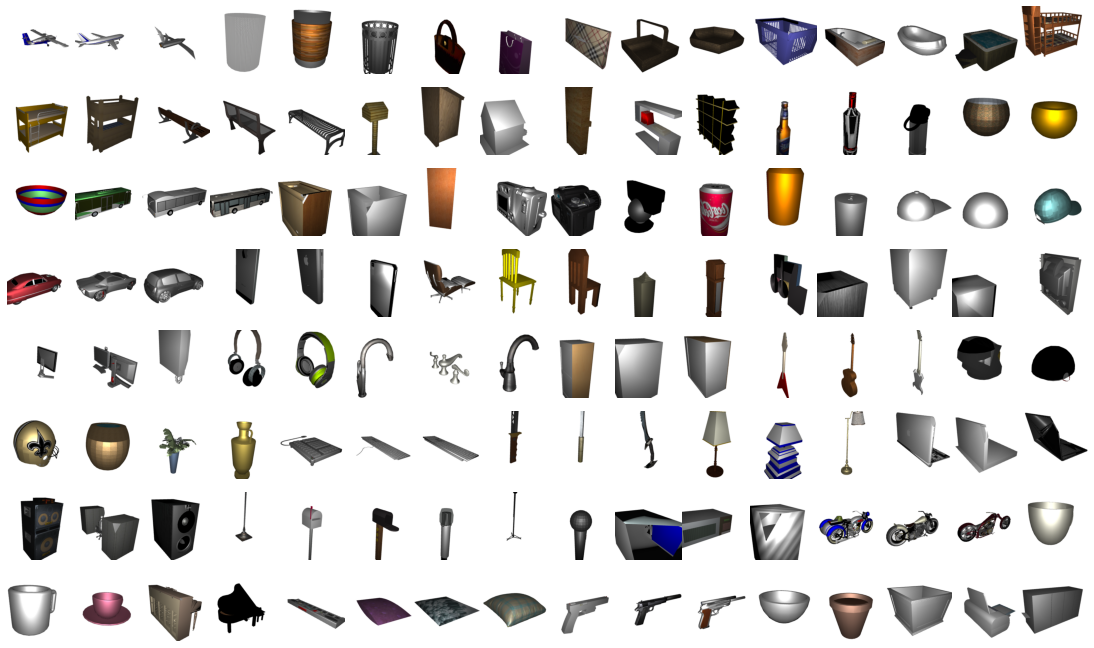

In [172]:
with DisableLogger():
    scene_list = []
    start_time = time.time()
    for obj_name in tqdm.tqdm(obj_list, desc = 'Loading Mesh'):
        # Load the FUZE bottle trimesh and put it in a scene
        mesh_or_scene =  trimesh.load(obj_name)
        if isinstance(mesh_or_scene, trimesh.Trimesh):
            mesh = pyrender.Mesh.from_trimesh(mesh_or_scene) 
            scene = pyrender.Scene()
            scene.add(mesh)
        else:
            scene = pyrender.Scene.from_trimesh_scene(mesh_or_scene)
        scene_list.append(scene)
    print("Loading Mesh: --- %s seconds ---" % (time.time() - start_time))




In [ ]:
images = np.zeros((128,224,224,3),dtype=np.int)
start_time = time.time()
##################################################################################
for idx, scene in tqdm.tqdm(enumerate(scene_list), desc = 'Rendering Mesh'):
    color = rendering(scene, camera, light, camera_pose)
    images[idx] = color
##################################################################################

print("Rendering Mesh: --- %s seconds ---" % (time.time() - start_time))
image_grid(images, rows=8, cols=16, rgb=True)

#### 